In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import random
import requests
import os
import textwrap

In [13]:
## create a substition cipher

letters1=list(string.ascii_lowercase)
letters2=list(string.ascii_lowercase)

true_mapping={}
random.shuffle(letters2)

for k,v in zip(letters1,letters2):
    true_mapping[k]=v

In [54]:
##initiate markov matrix
M=np.ones((26,26))

#initiate state distribution
pi=np.zeros(26)

#update markov matrix
def update_transition(ch1,ch2):
    i=ord(ch1)-97
    j=ord(ch2)-97
    M[i,j]+=1
    
#update initial state variable
def update_pi(ch1):
    i=ord(ch1)-97
    pi[i]+=1
    
#get log-probability
def get_word_prob(word):
    i=ord(word[0])-97
    logp=np.log(pi[i])
    
    for ch in word[1:]:
        j=ord(ch)-97
        logp+=np.log(M[i,j])
        i=j
        
    return logp

#get probability of a sequence of words

def get_sequence_prob(words):
    if type(words)==str:
        words=words.split()
    
    logp=0
    for word in words:
        logp+=get_word_prob(word)
    
    return logp

In [39]:
#download file

if not os.path.exists("./datasets/moby_dick.txt"):
    r=requests.get("https://lazyprogrammer.me/course_files/moby_dick.txt")
    with open("datasets/moby_dick.txt",'w',encoding="utf-8") as f:
        f.write(r.content.decode())

In [57]:
#for replacing non alpha characters
regex=re.compile('[^a-zA-Z]')

#load in words

for line in open('datasets/moby_dick.txt','r',encoding="utf-8"):
    line=line.rstrip()
    
    if line:
        line=regex.sub(' ',line)#replace all non-alpha characters with space
        
        #convert to lowercase and split into tokens
        tokens=line.lower().split()
        
        for token in tokens:
            #update the model
            
            #first word
            ch0=token[0]
            update_pi(ch0)
            
            #other letters
            for ch1 in token[1:]:
                update_transition(ch0,ch1)
                ch0=ch1

#normalize probability
pi/=pi.sum()
M/=M.sum(axis=1, keepdims=True)

In [59]:
## encode a message

original_message='''I then lounged down the street and found, as I expected, that there was a mews in a lane which runs down by one 
                    wall of the garden. I lent the ostlers a hand in rubbing down their horses, and received in exchange twopence, a glass of 
                    half-and-half, two fills of shag tobacco, and as much information as I could desire about Miss Adler, to say nothing of half 
                    a dozen other people in the neighbourhood in whom I was not in the least interested, but whose biographies I was compelled to 
                    listen to'''

In [60]:
def encode_message(msg):
    msg=msg.lower()
    
    msg=regex.sub(' ',msg) # replace non-alpha characters
    
    coded_msg=[]
    for ch in msg:
        coded_ch=ch #could just be a space
        
        if ch in true_mapping:
            coded_ch=true_mapping[ch]
        coded_msg.append(coded_ch)
    
    return ''.join(coded_msg)

encoded_message=encode_message(original_message)

#function to decode a message

def decode_message(msg,word_map):
    decoded_msg=[]
    for ch in msg:
        decoded_ch=ch
        if ch in word_map:
            decoded_ch=word_map[ch]
        decoded_msg.append(decoded_ch)
    
    return ''.join(decoded_msg)

In [61]:
### run evolutionary algorithm

dna_pool=[]
for i in range(20):
    dna=list(string.ascii_lowercase)
    random.shuffle(dna)
    dna_pool.append(dna)

In [62]:
def evolve_offspring(dna_pool,n_children):
    #make n children per offspring
    offspring=[]
    
    for dna in dna_pool:
        for i in range(n_children):
            copy=dna.copy()
            j=np.random.randint(len(copy))
            k=np.random.randint(len(copy))
            
            #switch
            tmp=copy[j]
            copy[j]=copy[k]
            copy[k]=tmp
            offspring.append(copy)
            
    return offspring+dna_pool

In [63]:
num_iters=1000
scores=np.zeros(num_iters)
best_dna=None
best_map=None
best_score=float('-inf')

for i in range(num_iters):
    if i>0:
        #get offspirng from the current dna pool
        dna_pool=evolve_offspring(dna_pool,3)
        
    #calculate score for each dna
    dna2score={}
    for dna in dna_pool:
        #populate map
        current_map={}
        for k,v in zip(letters1,dna):
            current_map[k]=v
            
        decoded_message=decode_message(encoded_message,current_map)
        score=get_sequence_prob(decoded_message)
        
        #store it 
        #needs to be a string to be dict key
        dna2score[''.join(dna)]=score
        
        #record the best so far
        if score>best_score:
            best_score=score
            best_dna=dna
            best_map=current_map
    
    #average score for this generation
    scores[i]=np.mean(list(dna2score.values()))
    
    #keep the best 5 score
    #also turn them back into list of single chars
    sorted_dna=sorted(dna2score.items(), key=lambda x:x[1], reverse=True)
    dna_pool=[list(k) for k,v in sorted_dna[:5]]
    
    if i%200==0:
        print("iter:",i,"score:",scores[i],"best so far:",best_score)

iter: 0 score: -2718.9619570714285 best so far: -2345.189037050503
iter: 200 score: -1161.1357835646509 best so far: -983.0592540281185
iter: 400 score: -1014.2388374327206 best so far: -929.8728464085292
iter: 600 score: -1098.0718902392232 best so far: -929.5136856065989
iter: 800 score: -1118.8855226327184 best so far: -929.5136856065989


In [67]:
decoded_message=decode_message(encoded_message,best_map)

print("LL of decoded message: ",get_sequence_prob(decoded_message))
print("LL of true message: ",get_sequence_prob(regex.sub(' ',original_message.lower())))

#which letters were wrong
for true,v in true_mapping.items():
    pred=best_map[v]
    if true!=pred:
        print("true: %s, pred: %s "% (true,pred))

LL of decoded message:  -929.5136856065989
LL of true message:  -932.9508705551947
true: j, pred: q 
true: k, pred: j 
true: q, pred: z 
true: z, pred: k 


In [68]:
#preint final decoded message
print("Decoded message: \n",textwrap.fill(decoded_message))
print("\nOriginal message: \n",original_message)

Decoded message: 
 i then lounged down the street and found  as i expected  that there
was a mews in a lane which runs down by one                      wall
of the garden  i lent the ostlers a hand in rubbing down their horses
and received in exchange twopence  a glass of
half and half  two fills of shag tobacco  and as much information as i
could desire about miss adler  to say nothing of half
a doken other people in the neighbourhood in whom i was not in the
least interested  but whose biographies i was compelled to
listen to

Original message: 
 I then lounged down the street and found, as I expected, that there was a mews in a lane which runs down by one 
                    wall of the garden. I lent the ostlers a hand in rubbing down their horses, and received in exchange twopence, a glass of 
                    half-and-half, two fills of shag tobacco, and as much information as I could desire about Miss Adler, to say nothing of half 
                    a dozen other people in

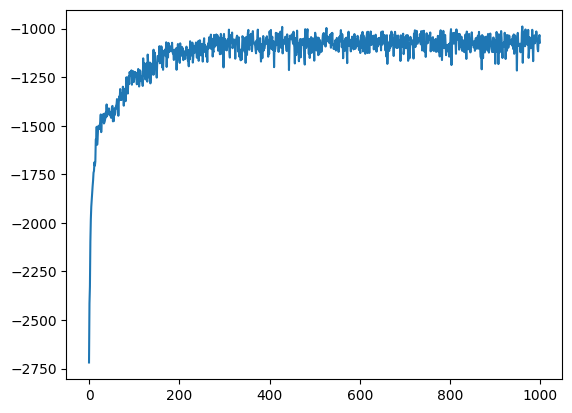

In [69]:
plt.plot(scores)
plt.show()